     |████████████████████████████████| 80 kB 4.1 MB/s 
     |████████████████████████████████| 1.1 MB 13.5 MB/s 
Mon Feb 14 11:25:04 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+---------------------

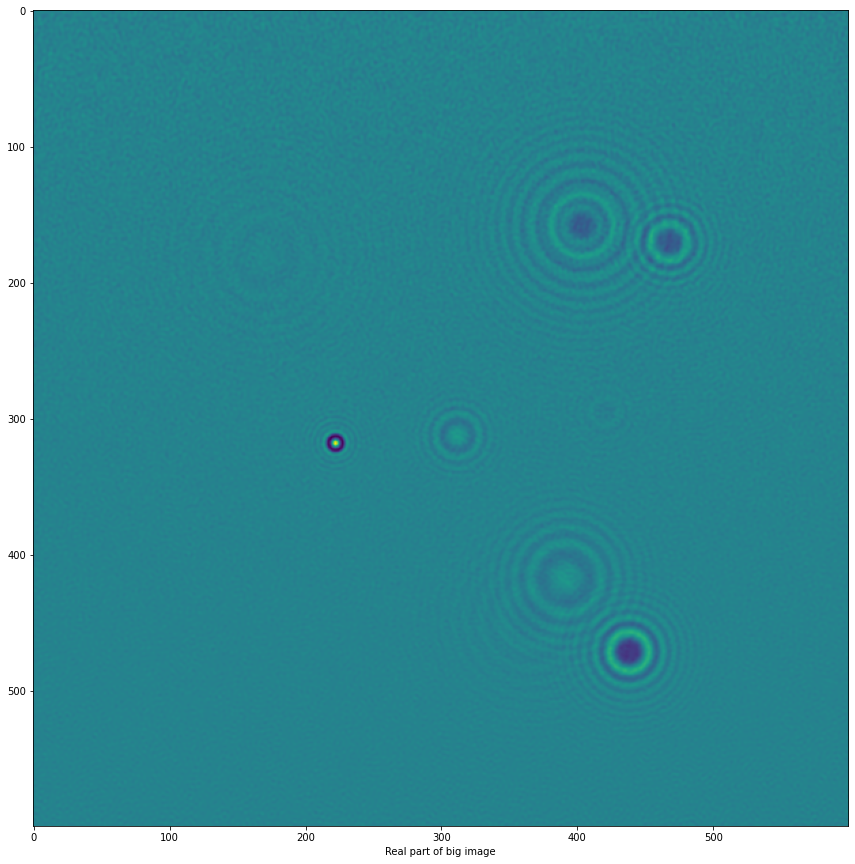

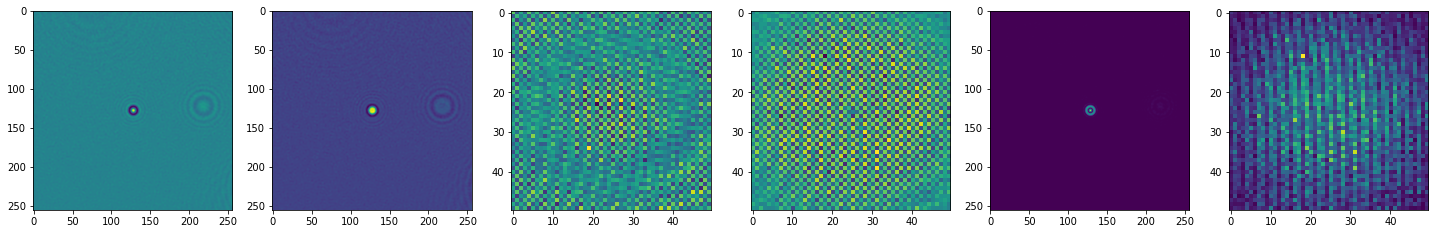

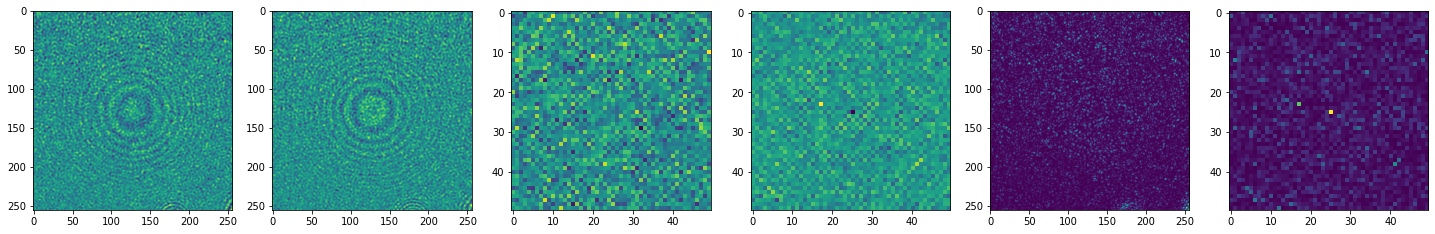

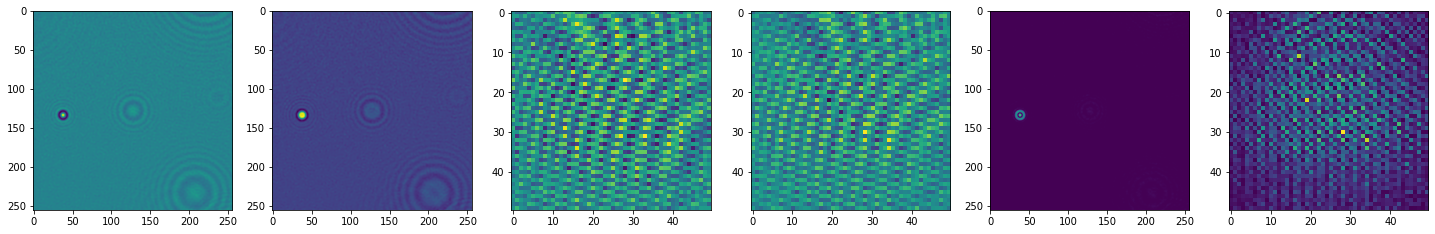

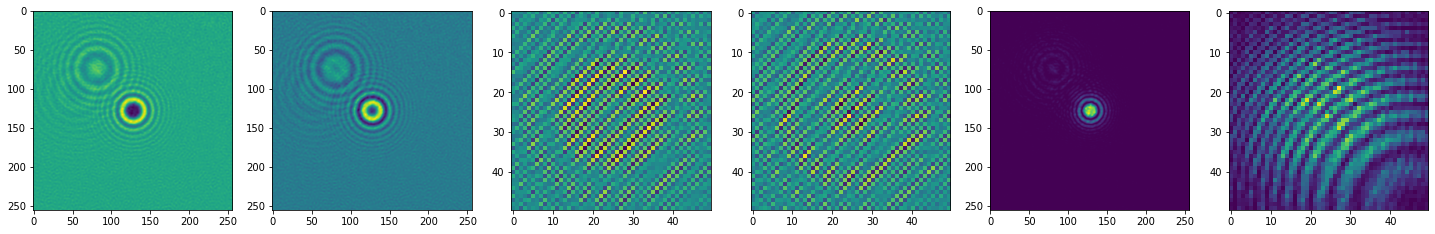

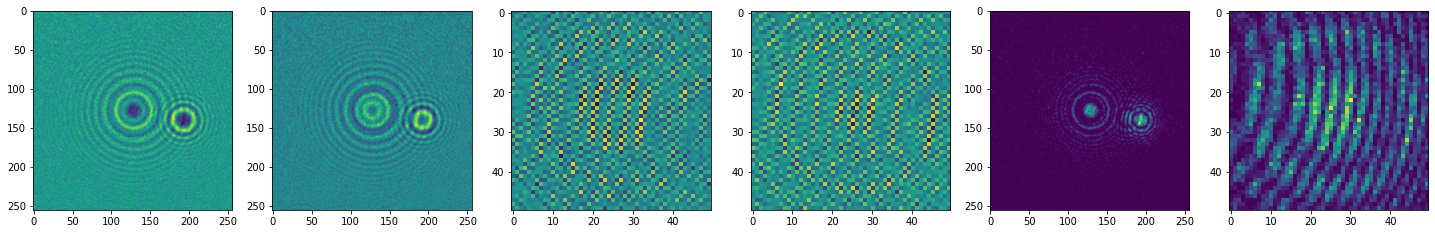

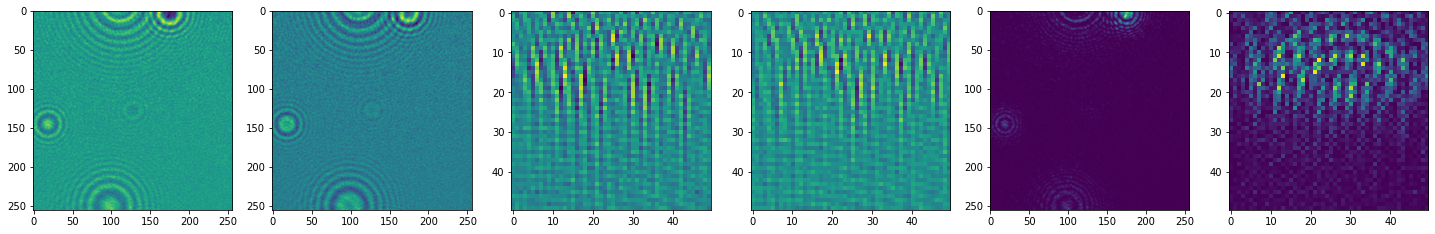

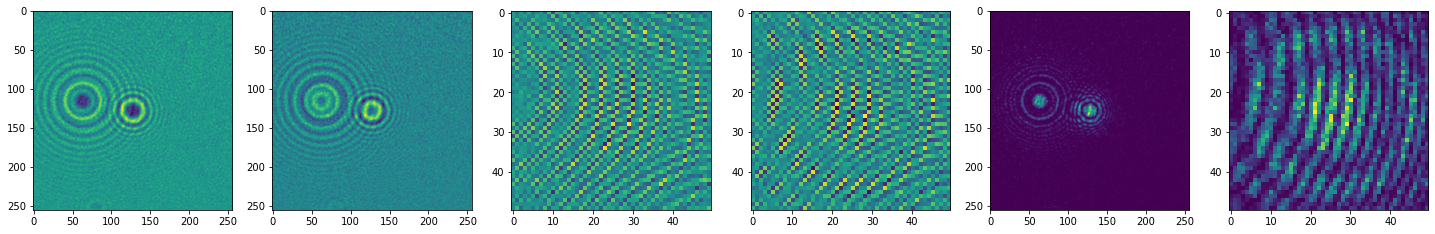

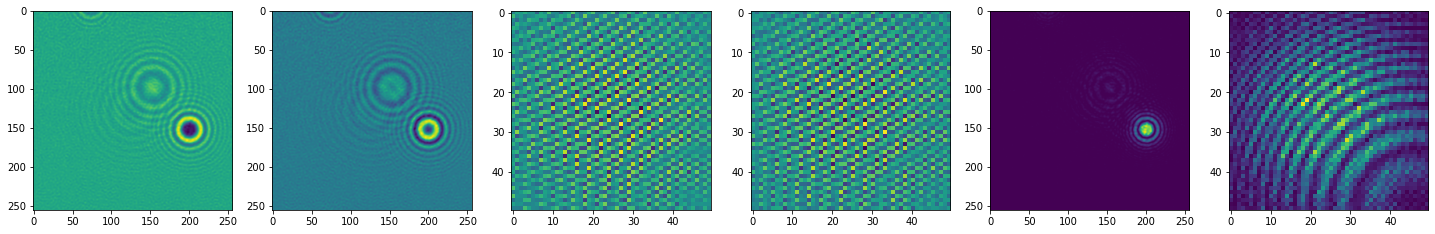

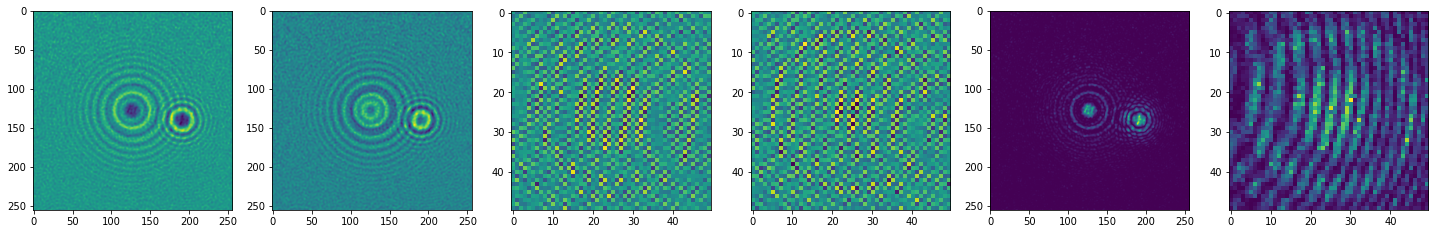

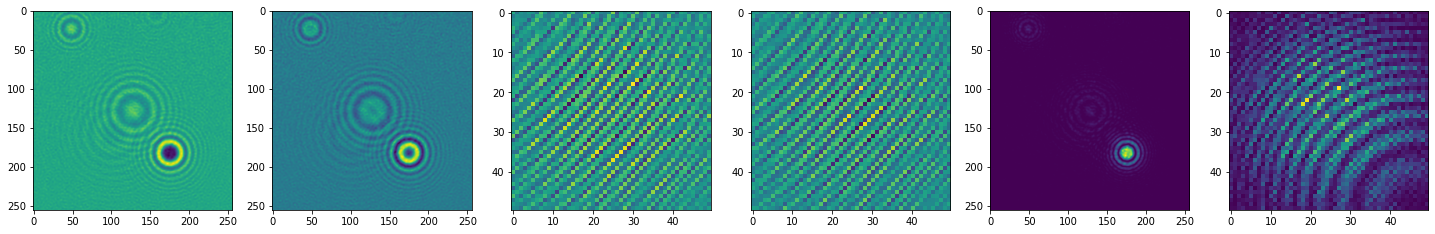

In [2]:
"""Import everything we need and check gpu"""

%matplotlib inline

already_installed = !pip list -v | grep deeptrack
if not already_installed:
    !pip install deeptrack==0.11.3

import numpy as np
import matplotlib.pyplot as plt
import deeptrack as dt
import keras.backend as K
import keras.optimizers as optimizers
import os
from matplotlib import image
from keras.layers import Layer
from google.colab import files
from cycler import cycler
from matplotlib import colors
from google.colab import drive
from numpy.fft import fft2, ifft2, fftshift
from keras import layers, models, datasets

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

"""Define the optics."""

IMAGE_SIZE = 600
SUB_IMAGE_SIZE = 256
FOURIER_IMAGE_SIZE = 50
NUMBER_OF_PARTICLES = 10

particle = dt.MieSphere(
    position=lambda: SUB_IMAGE_SIZE//2 + (IMAGE_SIZE-SUB_IMAGE_SIZE) * np.random.rand(2),
    z=lambda: -150 + np.random.random() * 300,
    radius=lambda: 1.5e-7 + 3e-7 * np.random.rand() ,
    refractive_index=lambda: np.random.uniform(0, 0.15) + 1.45,
    L=8,
    position_unit="pixel",
)

HC = dt.HorizontalComa(coefficient=lambda c1: c1, c1=0 + np.random.randn() * 0.05)
VC = dt.VerticalComa(coefficient=lambda c2:c2, c2=0 + np.random.randn() * 0.05)

def crop(pupil_radius):
    def inner(image):
        x = np.arange(image.shape[0]) - image.shape[0] / 2
        y = np.arange(image.shape[1]) - image.shape[1] / 2
        X, Y = np.meshgrid(x, y)
        image[X ** 2 + Y ** 2 > pupil_radius ** 2] = 0
        return image
    return inner
CROP = dt.Lambda(crop, pupil_radius=IMAGE_SIZE)

optics = dt.Brightfield(
    NA=1.3,
    resolution=1.13e-6,
    wavelength=525e-9,
    #aperature_angle=53.7 * 2 * np.pi / 360,
    polarization_angle=lambda: np.random.rand() * 2 * np.pi,
    magnification=10,
    output_region=(0, 0, IMAGE_SIZE, IMAGE_SIZE),
    padding=(64,) * 4,
    return_field=True,
    pupil=HC+VC + CROP,
)

real_noise = dt.Gaussian(
    mu=0, 
    sigma=lambda level: np.random.rand() * 0.05,
)

noise = real_noise + dt.Gaussian(
    mu=0, 
    sigma=lambda real_sigma: real_sigma * 0.05j,
    real_sigma=real_noise.sigma
)

gradient = dt.IlluminationGradient(
    gradient=lambda: np.random.randn(2) * 5e-5,
)


"""Generating sub-images"""
def crop_center(img, cropx, cropy):
    y,x = img.shape
    startx = x//2 - cropx//2
    starty = y//2 - cropy//2    
    return img[starty:starty+cropy, startx:startx+cropx]

def fourier_func():
    def inner(image):
        OUTDIM = 35
        output = np.zeros((OUTDIM, OUTDIM, 2))
        ft = fftshift(fft2(image[:,:,0]))
        output[:,:,0] = crop_center(np.imag(ft), OUTDIM, OUTDIM)
        output[:,:,1] = crop_center(np.real(ft), OUTDIM, OUTDIM)
        return output
    return inner

def func():
    def inner(image):
        image = (image - 1)
        output = np.zeros((*image.shape[:2], 2))
        output[..., 0:1] = np.real(image)
        output[..., 1:2] = np.imag(image)
        return output
    return inner

def normalization_func():
    def inner(image):
        output = np.zeros((*image.shape[:2], 2))
        output[:,:,0] = image[:,:,0] - np.min(image[:,:,0])
        output[:,:,1] = image[:,:,1] - np.min(image[:,:,1])
        return output
    return inner

def create_sub_images(image_of_particles, sub_image_size):
    positions = [property["position"] for property in image_of_particles.properties  if "position" in property]
    sub_images = []
    for point in positions:
        sub_image_row = np.arange( round(point[0]-sub_image_size[0]/2), round(point[0]+sub_image_size[0]/2+1))
        sub_image_column = np.arange(round(point[1]-sub_image_size[1]/2), round(point[1]+sub_image_size[1]/2+1))
        sub_images.append(image_of_particles[sub_image_row[0]:sub_image_row[-1],sub_image_column[0]:sub_image_column[-1]])
    return sub_images

complex_to_float = dt.Lambda(func)
fourier = dt.Lambda(fourier_func)
normalization = dt.Lambda(normalization_func)
particles = particle ** NUMBER_OF_PARTICLES
multiparticle_dataset = optics(particles + noise + gradient) + complex_to_float
test_image = multiparticle_dataset.update().resolve()

#Plotting the sub-images of all the particles.
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
ax.imshow(test_image[:,:,0])
ax.set_xlabel("Real part of big image")
plt.show()

sub_images = create_sub_images(test_image, (SUB_IMAGE_SIZE, SUB_IMAGE_SIZE))
for img in sub_images:
    fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(25,8))
    ax1.imshow(img[:,:,0])
    ax2.imshow(img[:,:,1])
    ft = fftshift(fft2(img[:,:,0]+1j*img[:,:,1])-np.mean(img[:,:,0]+1j*img[:,:,1]))
    ax3.imshow(crop_center(np.real(ft), FOURIER_IMAGE_SIZE, FOURIER_IMAGE_SIZE))
    ax4.imshow(crop_center(np.imag(ft), FOURIER_IMAGE_SIZE, FOURIER_IMAGE_SIZE))
    ax5.imshow(np.abs(img[:,:,0])**2)
    ax6.imshow(crop_center(np.abs(ft)**2, FOURIER_IMAGE_SIZE, FOURIER_IMAGE_SIZE))
    plt.show()

In [3]:
"""Loading models"""
NUMBER_OF_MODELS = 10
drive.mount('/content/drive')

def load_models(path):
    loaded_models = []
    for i in range(NUMBER_OF_MODELS):
        model = models.Sequential()
        loaded_models.append(models.load_model(path))
    return loaded_models


Mounted at /content/drive


In [4]:
"""Importing models"""
rough_path = str("/content/drive/My Drive/rough_networks_feb14")
fine_path = str("/content/drive/My Drive/fine_networks_feb14")
#rough_model = load_models(rough_path)[0]
fine_model = load_models(fine_path)[0]

In [5]:
#@title 
def _propagate_field(field, Tz, z, x, y, K, C, k=2 * np.pi / 0.633):
    """
    Propagate field. Field =  a Complex array of row*col dimension
    """
    Field = np.fft.fft2(field)
    Field = C * Tz * Field
    Field = np.fft.ifft2(Field)

    return Field


def _precalc(field, px, k=2 * np.pi / 0.633):
    """
    Precalculate some constants for propagating field for faster computations.
    """
    yr, xr = field.real.shape

    x = 2 * np.pi / px * np.arange(-(xr / 2 - 1 / 2), (xr / 2 + 1 / 2), 1) / xr
    y = 2 * np.pi / px * np.arange(-(yr / 2 - 1 / 2), (yr / 2 + 1 / 2), 1) / yr
    KXk, KYk = np.meshgrid(x, y)

    K = np.real(
        np.sqrt(np.array(1 - (KXk / k) ** 2 - (KYk / k) ** 2, dtype=np.complex64))
    )
    # Create a circular disk here.
    C = np.fft.fftshift(((KXk / k) ** 2 + (KYk / k) ** 2 < 1) * 1.0)

    return x, y, K, C


def _precalc_Tz(k, zv, K, C):
    return [C * np.fft.fftshift(np.exp(k * 1j * z * (K - 1))) for z in zv]


def propagation_matrix(
    z,
    shape=(IMAGE_SIZE, IMAGE_SIZE),
    padding=64,
    wavelength=525e-9,
    pixel_size=1.13e-6,
):

    field = np.zeros(np.array(shape) + padding * 2)
    k = 2 * np.pi / wavelength * 1e-6
    x, y, K, C = _precalc(field, pixel_size * 1e6, k)
    return _precalc_Tz(k, z, K, C)


class Rescale(dt.Feature):
    """Rescales an optical field.
    Parameters
    ----------
    i : int
        index of z-propagator matrix
    """

    def __init__(self, rescale=1, **kwargs):
        super().__init__(rescale=rescale, **kwargs)

    def get(self, image, rescale, **kwargs):
        image = np.array(image)
        im=image[...,0]+1j*image[...,1]
        im=(rescale*(np.abs(im)-1)+1)*np.exp(1j*np.angle(im))
        image[..., 0] = im.real
        image[..., 1] = im.imag
        return image
        

    

class RotateField(dt.Feature):
    def __init__(self, angle=0, **kwargs):
        super().__init__(angle=angle, **kwargs)

    def get(self, image, angle, **kwargs):
        image = np.array(image)
        im2=np.copy(image)
        im2[...,0]-=1
        im2[...,0]=np.cos(angle)*image[...,0]+np.sin(angle)*image[...,1]
        im2[...,1]=np.cos(angle)*image[...,1]-np.sin(angle)*image[...,0]
        image=im2
        image[...,0]+=1

        return image

    
class PhaseShift(dt.Feature):
    def __init__(self, angle=0, **kwargs):
        super().__init__(angle=angle, **kwargs)

    def get(self, image, angle, **kwargs):
        image = np.array(image)
        im2=np.copy(image)
        im2[...,0]=np.cos(angle)*image[...,0]-np.sin(angle)*image[...,1]
        im2[...,1]=np.cos(angle)*image[...,1]+np.sin(angle)*image[...,0]
        image=im2

        return image
class RescalePhase(dt.Feature):
    """Rescales the phase of an optical field.
    Parameters
    ----------
    i : int
        index of z-propagator matrix
    """

    def __init__(self, phasescale=1, **kwargs):
        super().__init__(phasescale=phasescale, **kwargs)

    def get(self, image, phasescale, **kwargs):
        image = np.array(image)
        im=image[...,0]+1j*image[...,1]
        im=np.abs(im)*np.exp(1j*phasescale*np.angle(im))
        image[..., 0] = im.real
        image[..., 1] = im.imag

        return image

class FourierTransform(dt.Feature):
    """Creates matrices for propagating an optical field.
    Parameters
    ----------
    i : int
        index of z-propagator matrix
    """

    def __init__(self, padding=(32,32), **kwargs):
        super().__init__(padding=padding, **kwargs)

    def get(self, image, padding, **kwargs):
        im = np.copy(image[..., 0] + 1j * image[..., 1])
        im = np.pad(im, (padding, padding), mode="symmetric")
        f1 = np.fft.fft2(im)
        return f1


class InverseFourierTransform(dt.Feature):
    """Creates matrices for propagating an optical field.
    Parameters
    ----------
    i : int
        index of z-propagator matrix
    """

    def __init__(self, padding=(32,32), **kwargs):
        super().__init__(padding=padding, **kwargs)

    def get(self, image, padding, **kwargs):
        im = np.fft.ifft2(image)
        imnew = np.zeros(
            (image.shape[0] - padding * 2, image.shape[1] - padding * 2, 2)
        )
        imnew[..., 0] = np.real(im)
        imnew[..., 1] = np.imag(im)
        return imnew


class FourierTransformTransformation(dt.Feature):
    def __init__(self, Tz=1, Tzinv=1, i: dt.PropertyLike[int] = 0, **kwargs):
        super().__init__(Tz=Tz, Tzinv=Tzinv, i=i, **kwargs)

    def get(self, image, Tz, Tzinv, i, **kwargs):

        if i < 0:
            propfac=1
            for j in range(int(np.abs(i))):
                propfac*=Tzinv
            image *= propfac
        else:
            propfac=1
            for j in range(int(np.abs(i))):
                propfac*=Tz
            image *= Tz ** i
        return image

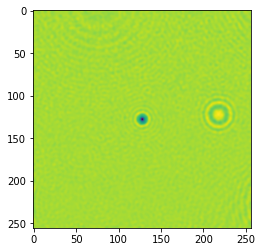

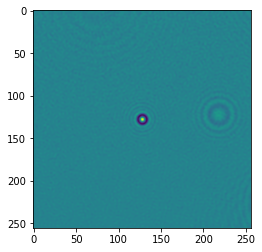

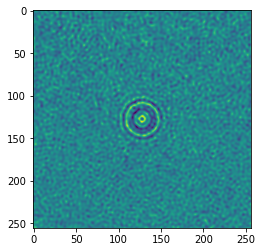

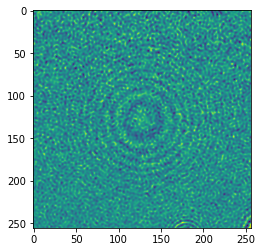

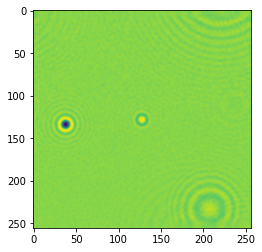

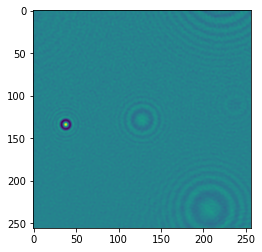

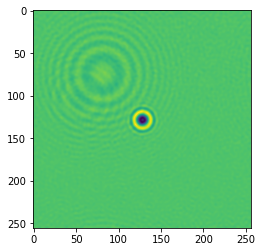

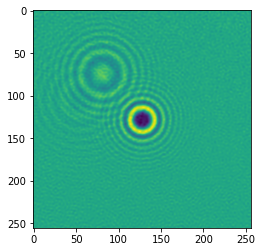

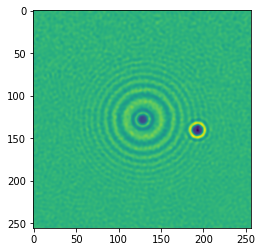

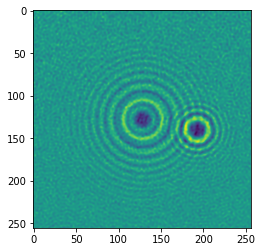

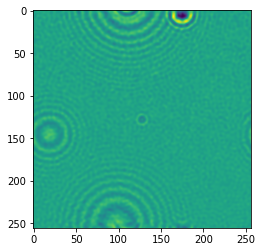

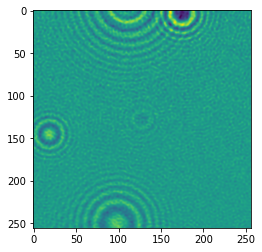

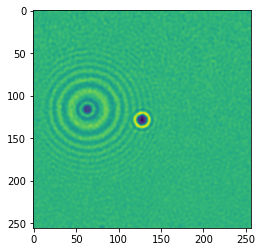

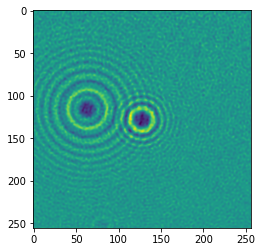

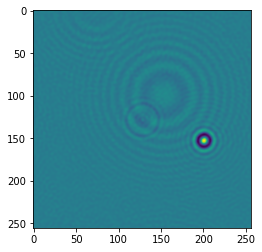

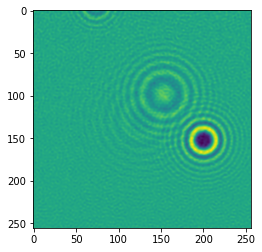

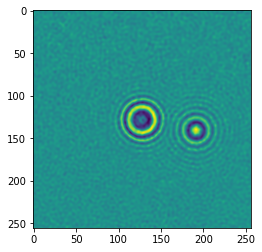

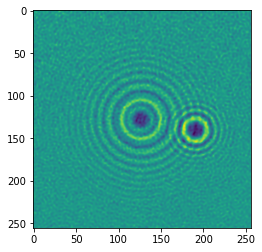

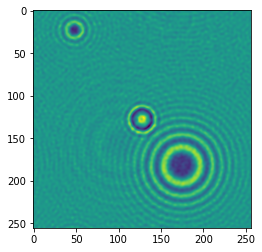

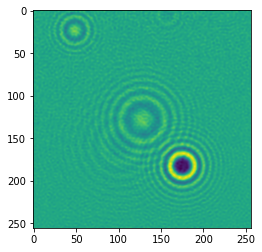

z-position: -13.82995485817358, predicted: -11.544783587803096, error: -2.2851712703704834
z-position: -134.20874310747465, predicted: -134.20874310747465, error: 0.0
z-position: -39.42591751404187, predicted: -39.27923106439492, error: -0.14668644964694977
z-position: 51.6068430699527, predicted: 58.485942439001775, error: -6.879099369049072
z-position: 45.28235223741305, predicted: 45.28235223741305, error: 0.0
z-position: 31.13122144410903, predicted: 31.740145177343436, error: -0.6089237332344055
z-position: 46.37318097293783, predicted: 49.464453803900966, error: -3.0912728309631348
z-position: 124.2730453014322, predicted: 126.26499283313234, error: -1.9919475317001343
z-position: 134.67463731683796, predicted: 137.43447232164448, error: -2.7598350048065186
z-position: -103.88466577557728, predicted: -103.88466577557728, error: 0.0


In [6]:
"""Approximating the z-positions of all the particles in the sub-images"""
#rough_z_predictions = rough_model.predict(np.array(sub_images))
rough_z_predictions = [property["z"] for property in test_image.properties  if "z" in property]

"""Re-propagating the images using PAS"""
repropagated_sub_images = []
for z, sub_image in zip(rough_z_predictions, sub_images):
    z *= -1
    propagate_up, propagate_down = propagation_matrix([.05, -.05], shape=(SUB_IMAGE_SIZE, SUB_IMAGE_SIZE), padding=0, wavelength=optics.wavelength.current_value, pixel_size=optics.voxel_size.current_value[0])
    temp = FourierTransform(padding=0).get(sub_image, padding=0)
    temp = FourierTransformTransformation().get(temp, propagate_down, propagate_up, z)
    repropagated_sub_image = InverseFourierTransform(padding=0).get(temp, padding=0)
    repropagated_sub_images.append(repropagated_sub_image)

    plt.imshow(repropagated_sub_image[:,:,0])
    plt.show()
    plt.imshow(sub_image[:,:,0])
    plt.show()

repropagated_sub_images = np.stack(
    ([crop_center(image, 64, 64) for image in np.array(repropagated_sub_images)[:,:,:,0]], [crop_center(image, 64, 64) for image in np.array(repropagated_sub_images)[:,:,:,1]]),
    axis=3,
    )

"""Using the re-propagated images to find the 'final' z-position"""
z_predictions = fine_model.predict(np.array(repropagated_sub_images))
z_predictions = np.array(z_predictions)[:,0] + np.array(rough_z_predictions)

z_positions = np.array([property["z"] for property in test_image.properties  if "position" in property])
for i in range(len(z_positions)):
    print(f"z-position: {z_positions[i]}, predicted: {z_predictions[i]}, error: {z_positions[i]-z_predictions[i]}")